In [92]:
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import math
from util.validation import validation
validation = validation()

In [2]:
# 確率推定テスト

In [94]:
def softmax(a):
    # 一番大きい値を取得
    c = np.max(a)
    # 各要素から一番大きな値を引く（オーバーフロー対策）
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    # 要素の値/全体の要素の合計
    y = exp_a / sum_exp_a

    return y 

In [3]:
df = pd.read_csv('csv/boat_race_data_tmp.csv')

/Users/yuta_miyawaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,50,86,122) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df = df[df['race_date'] >= 20170000]

In [5]:
PARTS = {'キャリボ': 4,
                 'ピストン': 4,
                 'リング': 3,
                 '電気': 2, 
                 'キャブ': 3,
                 'ギヤ': 2,
                 'シリンダ': 4,
                 'シャフト': 4}
def parts_count(x, key, num):
    x = str(x)
    if x.find(key) != -1:
        if x[x.find(key):].find('×') != -1:
            return x[x.find(key)+num+1]
        else:
            return 1
    else:
        return 0

def drop_miss(df):
    return df[df['is_miss'] == False]

def conv_time(x):
    if str(x).find('nan') != -1:
        return x
    elif str(x).find(':') == -1:
        return np.nan
    else:
        time = x.split(':')
        return float(time[0])*60 + float(time[1]) + float(time[2])/10
        
def preprocessing(df):
    # 月
    df['month'] = df['race_date'].apply(lambda x: (x%10000)//100)
    df['month_old1'] = df['race_date_old1'].apply(lambda x: (x%10000)//100)
    df['month_old2'] = df['race_date_old2'].apply(lambda x: (x%10000)//100)
    df['month_old3'] = df['race_date_old3'].apply(lambda x: (x%10000)//100)
    # 日
    df['date'] = df['race_date'].apply(lambda x: x%100)
    df['date_old1'] = df['race_date_old1'].apply(lambda x: x%100)
    df['date_old2'] = df['race_date_old2'].apply(lambda x: x%100)
    df['date_old3'] = df['race_date_old3'].apply(lambda x: x%100)
    
    # 周期データを三角関数に変換
    # 月
    df['month_cos'] = np.cos(2 * np.pi * df['month']/df['month'].max())
    df['month_sin'] = np.sin(2 * np.pi * df['month']/df['month'].max())
    df['month_cos_old1'] = np.cos(2 * np.pi * df['month_old1']/df['month_old1'].max())
    df['month_sin_old1'] = np.sin(2 * np.pi * df['month_old1']/df['month_old1'].max())
    df['month_cos_old2'] = np.cos(2 * np.pi * df['month_old2']/df['month_old2'].max())
    df['month_sin_old2'] = np.sin(2 * np.pi * df['month_old2']/df['month_old2'].max())
    df['month_cos_old3'] = np.cos(2 * np.pi * df['month_old3']/df['month_old3'].max())
    df['month_sin_old3'] = np.sin(2 * np.pi * df['month_old3']/df['month_old3'].max())
    # 日
    df['date_cos'] = np.cos(2 * np.pi * df['date']/df['date'].max())
    df['date_sin'] = np.sin(2 * np.pi * df['date']/df['date'].max())
    df['date_cos_old1'] = np.cos(2 * np.pi * df['date_old1']/df['date_old1'].max())
    df['date_sin_old1'] = np.sin(2 * np.pi * df['date_old1']/df['date_old1'].max())
    df['date_cos_old2'] = np.cos(2 * np.pi * df['date_old2']/df['date_old2'].max())
    df['date_sin_old2'] = np.sin(2 * np.pi * df['date_old2']/df['date_old2'].max())
    df['date_cos_old3'] = np.cos(2 * np.pi * df['date_old3']/df['date_old3'].max())
    df['date_sin_old3'] = np.sin(2 * np.pi * df['date_old3']/df['date_old3'].max())
    # コース方向
    df['course_direction_cos'] = np.cos(2 * np.pi * df['course_direction']/df['course_direction'].max())
    df['course_direction_sin'] = np.sin(2 * np.pi * df['course_direction']/df['course_direction'].max())
    df['course_direction_cos_old1'] = np.cos(2 * np.pi * df['course_direction_old1']/df['course_direction_old1'].max())
    df['course_direction_sin_old1'] = np.sin(2 * np.pi * df['course_direction_old1']/df['course_direction_old1'].max())
    df['course_direction_cos_old2'] = np.cos(2 * np.pi * df['course_direction_old2']/df['course_direction_old2'].max())
    df['course_direction_sin_old2'] = np.sin(2 * np.pi * df['course_direction_old2']/df['course_direction_old2'].max())
    df['course_direction_cos_old3'] = np.cos(2 * np.pi * df['course_direction_old3']/df['course_direction_old3'].max())
    df['course_direction_sin_old3'] = np.sin(2 * np.pi * df['course_direction_old3']/df['course_direction_old3'].max())
    # 風方向
    df['wind_direction_cos'] = np.cos(2 * np.pi * df['wind_direction']/df['wind_direction'].max())
    df['wind_direction_sin'] = np.sin(2 * np.pi * df['wind_direction']/df['wind_direction'].max())
    df['wind_direction_cos_old1'] = np.cos(2 * np.pi * df['wind_direction_old1']/df['wind_direction_old1'].max())
    df['wind_direction_sin_old1'] = np.sin(2 * np.pi * df['wind_direction_old1']/df['wind_direction_old1'].max())
    df['wind_direction_cos_old2'] = np.cos(2 * np.pi * df['wind_direction_old2']/df['wind_direction_old2'].max())
    df['wind_direction_sin_old2'] = np.sin(2 * np.pi * df['wind_direction_old2']/df['wind_direction_old2'].max())
    df['wind_direction_cos_old3'] = np.cos(2 * np.pi * df['wind_direction_old3']/df['wind_direction_old3'].max())
    df['wind_direction_sin_old3'] = np.sin(2 * np.pi * df['wind_direction_old3']/df['wind_direction_old3'].max())
    # 風とコースの差分方向
    df['course_wind_direction_cos'] = np.cos(2 * np.pi * (df['wind_direction']/df['wind_direction'].max() - df['course_direction']/df['course_direction'].max()))
    df['course_wind_direction_sin'] = np.sin(2 * np.pi * (df['wind_direction']/df['wind_direction'].max() - df['course_direction']/df['course_direction'].max()))
    df['course_wind_direction_cos_old1'] = np.cos(2 * np.pi * (df['wind_direction_old1']/df['wind_direction_old1'].max() - df['course_direction_old1']/df['course_direction_old1'].max()))
    df['course_wind_direction_sin_old1'] = np.sin(2 * np.pi * (df['wind_direction_old1']/df['wind_direction_old1'].max() - df['course_direction_old1']/df['course_direction_old1'].max()))
    df['course_wind_direction_cos_old2'] = np.cos(2 * np.pi * (df['wind_direction_old2']/df['wind_direction_old2'].max() - df['course_direction_old2']/df['course_direction_old2'].max()))
    df['course_wind_direction_sin_old2'] = np.sin(2 * np.pi * (df['wind_direction_old2']/df['wind_direction_old2'].max() - df['course_direction_old2']/df['course_direction_old2'].max()))
    df['course_wind_direction_cos_old3'] = np.cos(2 * np.pi * (df['wind_direction_old3']/df['wind_direction_old3'].max() - df['course_direction_old3']/df['course_direction_old3'].max()))
    df['course_wind_direction_sin_old3'] = np.sin(2 * np.pi * (df['wind_direction_old3']/df['wind_direction_old3'].max() - df['course_direction_old3']/df['course_direction_old3'].max()))
    
    # 展示フライングフラグ
    df['pre_f_flg'] = df['pre_start_timing'].apply(lambda x: str(x).find('F')!=-1)
    df['pre_l_flg'] = df['pre_start_timing'].apply(lambda x: str(x).find('L')!=-1)
    df['pre_start_timing'] = df['pre_start_timing'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['pre_f_flg_old1'] = df['pre_start_timing_old1'].apply(lambda x: str(x).find('F')!=-1)
    df['pre_l_flg_old1'] = df['pre_start_timing_old1'].apply(lambda x: str(x).find('L')!=-1)
    df['pre_start_timing_old1'] = df['pre_start_timing_old1'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['start_timing_old1'] = df['start_timing_old1'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['pre_f_flg_old2'] = df['pre_start_timing_old2'].apply(lambda x: str(x).find('F')!=-1)
    df['pre_l_flg_old2'] = df['pre_start_timing_old2'].apply(lambda x: str(x).find('L')!=-1)
    df['pre_start_timing_old2'] = df['pre_start_timing_old2'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['start_timing_old2'] = df['start_timing_old2'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['pre_f_flg_old3'] = df['pre_start_timing_old3'].apply(lambda x: str(x).find('F')!=-1)
    df['pre_l_flg_old3'] = df['pre_start_timing_old3'].apply(lambda x: str(x).find('L')!=-1)
    df['pre_start_timing_old3'] = df['pre_start_timing_old3'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    df['start_timing_old3'] = df['start_timing_old3'].apply(lambda x: -1*float(x.replace('F', '0')) if str(x).find('F')!=-1 else (np.nan if str(x).find('L')!=-1 else float(x)))
    
    # パーツフラグと個数
    for key, values in PARTS.items():
        df[key+'_flg'] = df['parts'].apply(lambda x: True if str(x).find(key)!=-1 else False)
        df[key+'_count'] = df['parts'].apply(parts_count, key=key, num=PARTS[key])
        df[key+'_flg_old1'] = df['parts_old1'].apply(lambda x: True if str(x).find(key)!=-1 else False)
        df[key+'_count_old1'] = df['parts_old1'].apply(parts_count, key=key, num=PARTS[key])
        df[key+'_flg_old2'] = df['parts_old2'].apply(lambda x: True if str(x).find(key)!=-1 else False)
        df[key+'_count_old2'] = df['parts_old2'].apply(parts_count, key=key, num=PARTS[key])
        df[key+'_flg_old3'] = df['parts_old3'].apply(lambda x: True if str(x).find(key)!=-1 else False)
        df[key+'_count_old3'] = df['parts_old3'].apply(parts_count, key=key, num=PARTS[key])
        
    # 枠番
    df['bracket_num'] = df['bracket_no']
    df['bracket_num_old1'] = df['bracket_no_old1']
    df['bracket_num_old2'] = df['bracket_no_old2']
    df['bracket_num_old3'] = df['bracket_no_old3']
    
    # 過去レースタイム変換
    df['player_race_time_old1'] = df['player_race_time_old1'].apply(conv_time)
    df['player_race_time_old2'] = df['player_race_time_old2'].apply(conv_time)
    df['player_race_time_old3'] = df['player_race_time_old3'].apply(conv_time)
    
    # 特選フラグ
    #今度つくる
    
    # 前走からの日付
    #コンドツクル
    
    # n走前nullフラグ作成
    df['old1_is_null'] = df['race_date_old1'].apply(lambda x: np.isnan(x))
    df['old2_is_null'] = df['race_date_old2'].apply(lambda x: np.isnan(x))
    df['old3_is_null'] = df['race_date_old3'].apply(lambda x: np.isnan(x))
    
    # レース内統計
    group = df.groupby(['race_date', 'place_id', 'race_no'])
    stat_col = [
            'age', 'weight', 'f_count',
            'l_count', 'start_time_avg', 'first_rate_all', 'second_rate_all',
            'third_rate_all', 'first_rate_area', 'second_rate_area',
            'third_rate_area', 'motor_within_second_rate',
            'motor_within_third_rate', 'boat_within_second_rate',
            'boat_within_third_rate', 'pre_time', 'tilt_angle', 'adjust_weight'
            ]
    name_mean = {}
    name_std = {}
    name_max = {}
    name_min = {}
    name_rank = {}
    for c in stat_col:
        name_mean[c] = c + '_mean'
        name_std[c] = c + '_std'
        name_max[c] = c + '_max'
        name_min[c] = c + '_min'
    
    mean_data = group[stat_col].mean()
    std_data = group[stat_col].std()
    max_data = group[stat_col].max()
    min_data = group[stat_col].min()
    
    mean_data = mean_data.rename(columns = name_mean)
    std_data = std_data.rename(columns = name_std)
    max_data = max_data.rename(columns = name_max)
    min_data = min_data.rename(columns = name_min)
    
    df = pd.merge(df, mean_data, on = ['race_date', 'place_id','race_no'])
    df = pd.merge(df, std_data, on = ['race_date', 'place_id','race_no'])
    df = pd.merge(df, max_data, on = ['race_date', 'place_id','race_no'])
    df = pd.merge(df, min_data, on = ['race_date', 'place_id','race_no'])
    
    # ランキング
    group = df.groupby(['race_date', 'place_id', 'race_no'])
    rank_col = [
            'age', 'weight', 'start_time_avg', 'first_rate_all', 'second_rate_all',
            'third_rate_all', 'first_rate_area', 'second_rate_area',
            'third_rate_area', 'motor_within_second_rate',
            'motor_within_third_rate', 'boat_within_second_rate',
            'boat_within_third_rate', 'pre_time'
            ]
    for c in stat_col:
        name_rank[c] = c + '_rank'
    rank_data = group[rank_col].rank(ascending=True,method="first")
    rank_data = rank_data.rename(columns = name_rank)
    df = pd.concat([df, rank_data], axis = 1)
    
    # レース情報
    race_list = df[['race_date', 'place_id', 'race_no', 'bracket_no']]
    
    #One-Hot Encoding
    dummies_list = ['place_id','bracket_no','player_grade','branch','born_area','propeller','weather']
    past_dummies_list = ['place_id','bracket_no','player_grade','branch','born_area','propeller','weather','win_pattern']
    
    for c in past_dummies_list:
        for i in range(3):
            dummies_list.append(c+'_old'+str(i+1))
    for i in range(3):
        dummies_list.append('old'+str(i+1)+'_is_null')
    for key in PARTS.keys():
        dummies_list.append(key+'_flg')
        
    df = pd.get_dummies(data = df, columns = dummies_list)
    
    # 目的変数の抽出
    target = {}
    target['finish_order'] = df['finish_order']
    target['player_race_time'] = df['player_race_time']
    
    # 不要カラムの削除
    drop_list = ['race_date','race_date_no','is_miss','player_id','parts','parts_old1','parts_old2','parts_old3',
                        'motor_no','boat_no','finish_order','player_race_time','race_grade',
                        'start_timing','win_pattern','race_date_old1',
                        'is_miss_old1','player_id_old1','motor_no_old1',
                        'boat_no_old1','race_date_old2','is_miss_old2',
                        'player_id_old2','motor_no_old2','boat_no_old2',
                        'race_date_old3','is_miss_old3','player_id_old3',
                        'motor_no_old3','boat_no_old3',
                        'race_grade_old1', 'race_grade_old2', 'race_grade_old3']
    df.drop(drop_list, axis = 1, inplace=True)
    
    return [df, target, race_list]

In [6]:
df = drop_miss(df)
df, target, race_list = preprocessing(df)

In [7]:
race_list = race_list.reset_index(drop=True)
test_index = race_list[race_list['race_date']>=20190901].index

In [8]:
##### 目的変数作成 #####
# 検証用
val_target_order = target['finish_order'][test_index].values
val_target_first = target['finish_order'][test_index].apply(lambda x: 1 if x == 1 else 0).values
val_target_within_second = target['finish_order'][test_index].apply(lambda x: 0 if x > 2 or np.isnan(x) else 1).values
val_target_within_third = target['finish_order'][test_index].apply(lambda x: 0 if x > 3 or np.isnan(x) else 1).values

In [9]:
# 検証用
val_data = df.values[test_index]
del df
del target
gc.collect()
race_list = race_list.iloc[test_index].reset_index(drop=True)

In [10]:
first_model = lgb.Booster(model_file='model/first_model.txt')
second_model = lgb.Booster(model_file='model/second_model.txt')
third_model = lgb.Booster(model_file='model/third_model.txt')

In [11]:
output_first = first_model.predict(val_data)
output_second = second_model.predict(val_data)
output_third = third_model.predict(val_data)

In [97]:
sum(softmax(output_first[race.index][:,1]))

1.0

In [106]:
count = 0
result = []
for x, race in race_list.groupby(['race_date','place_id','race_no']):
    out_first = output_first[race.index][:,1]/sum(output_first[race.index][:,1])
    out_second = (2*output_second[race.index][:,1]/sum(output_second[race.index][:,1])) - out_first
    out_third = (2*output_third[race.index][:,1]/sum(output_third[race.index][:,1])) - out_second
#     print(x)
#     print(race)
#     print(out_first)
#     print(out_second)
#     print(out_third)
    bet = {}
    bet['race_date'] = x[0]
    bet['place_id'] = x[1]
    bet['race_no'] = x[2]
    bet['bet_type'] = 1
    bet['bracket2'] = 0
    bet['bracket3'] = 0
    bet['amount'] = 1
    for i, num in enumerate(race['bracket_no'].values):
        bet['bracket1'] = num
#         print(validation.betting(bet))
        result.append([out_first[i], validation.betting(bet)[1] > 0])
 

In [107]:
result

[[0.5574227275170224, True],
 [0.022453156556849846, False],
 [0.0617467733940917, False],
 [0.2368543204789774, False],
 [0.10998929476361619, False],
 [0.011533727289442524, False],
 [0.5395855494488924, False],
 [0.030694265919267258, False],
 [0.2903759747589158, False],
 [0.06960834912548632, False],
 [0.04683679772192066, False],
 [0.022899063025517623, True],
 [0.24825664429758354, True],
 [0.49710983624635896, False],
 [0.051401022043924306, False],
 [0.062375292005465495, False],
 [0.005863185984870309, False],
 [0.13499401942179715, False],
 [0.1724879384022929, False],
 [0.3824492273511499, True],
 [0.019904752218743577, False],
 [0.31023760564776365, False],
 [0.007885692803135537, False],
 [0.10703478357691441, False],
 [0.21053570148839354, False],
 [0.4547207154166699, False],
 [0.038604462301182044, False],
 [0.23426725692937211, True],
 [0.023088669635724684, False],
 [0.03878319422865759, False],
 [0.5055923909021744, True],
 [0.09826070798238035, False],
 [0.20496487

In [108]:
i = 50
list(filter(lambda x: x[0]>=i/100 and x[0]<(i+1)/100 and x[1] == True, result))


[[0.5055923909021744, True],
 [0.5035259719126973, True],
 [0.5031001756914454, True],
 [0.5038624113661471, True],
 [0.5039554331567956, True],
 [0.5057456658881053, True],
 [0.5099664317266721, True],
 [0.502093001111321, True],
 [0.5032090948395119, True],
 [0.508793979947954, True],
 [0.5055441651596078, True],
 [0.5056115651956105, True],
 [0.5025809513792232, True],
 [0.5074324433153391, True],
 [0.5038016285616524, True],
 [0.5086508555768572, True],
 [0.5005110938898968, True],
 [0.5002620262699913, True],
 [0.5006163197225886, True],
 [0.5017870952471555, True],
 [0.5065807568793221, True],
 [0.5082653877057025, True],
 [0.5063701632071328, True],
 [0.5060057168384106, True],
 [0.506131645150875, True],
 [0.5075800680897088, True],
 [0.5083935209530547, True],
 [0.5075958187367672, True],
 [0.5083666930882101, True],
 [0.5001683057541919, True],
 [0.5033628904635233, True],
 [0.5038197994697843, True],
 [0.5083493050368159, True],
 [0.5092133469550915, True],
 [0.5001115941467

In [109]:
pred = []
for i in range(100):
    try:
        pred.append(len(list(filter(lambda x: x[0]>=i/100 and x[0]<(i+1)/100 and x[1] == True, result)))/len(list(filter(lambda x: x[0]>=i/100 and x[0]<(i+1)/100, result))))
    except:
        pred.append(0)
    

In [110]:
pred

[0.001844532279314888,
 0.00888596346881685,
 0.01769136451217376,
 0.02341748993779729,
 0.04101951413779371,
 0.047291296625222023,
 0.058627752176139275,
 0.06662886305642189,
 0.07110826393337603,
 0.08783068783068783,
 0.10674603174603174,
 0.0993676603432701,
 0.11392405063291139,
 0.1254256526674234,
 0.13591022443890274,
 0.14533333333333334,
 0.14846818538884524,
 0.16727605118829983,
 0.15497076023391812,
 0.1689401888772298,
 0.18542336548767416,
 0.20357142857142857,
 0.1918194640338505,
 0.21649484536082475,
 0.22624434389140272,
 0.2407108239095315,
 0.2535211267605634,
 0.268389662027833,
 0.29568788501026694,
 0.27139874739039666,
 0.2799043062200957,
 0.284688995215311,
 0.33884297520661155,
 0.39002932551319647,
 0.3595505617977528,
 0.33152173913043476,
 0.3746130030959752,
 0.3674698795180723,
 0.3923611111111111,
 0.3413793103448276,
 0.3667711598746082,
 0.3625,
 0.4894366197183099,
 0.4918032786885246,
 0.4697508896797153,
 0.4935064935064935,
 0.4678899082568807

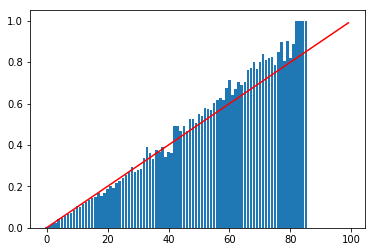

In [111]:
plt.bar([i for i in range(100)], pred)
plt.plot([i/100 for i in range(100)], 'red')

In [104]:
def rmse(target, predicted):
    ar = [(t-p)**2 for t, p in zip(target, predicted)]
    return math.sqrt(sum(ar)/len(ar))

In [112]:
rmse([i/100 for i in range(80)], pred[:80])

0.052012612942059715

In [35]:
test_bet = {'race_date': 20190901,
            'place_id': 5,
            'race_no': 1,
            'bet_type': 7,
            'bracket1': 1,
            'bracket2': 3,
            'bracket3': 4,
            'amount': 1
            }

In [36]:
print(validation.betting(test_bet))

[100, 1490.0]


In [37]:
test_bet

{'race_date': 20190901,
 'place_id': 5,
 'race_no': 1,
 'bet_type': 7,
 'bracket1': 1,
 'bracket2': 3,
 'bracket3': 4,
 'amount': 1}